# Sazonalidade nas viagens a serviço do governo federal

In [ ]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from pathlib import Path
from glob import glob

In [2]:
from importlib import reload
import xavy.explore as xe
import xavy.utils as xu
import xavy.dataframes as xd

## Funções

In [3]:
def load_cgu_csv(filename, float_cols=[], date_cols=[], low_memory=False):
    """
    Load a CSV file downloaded from CGU's Portal da Transparência.
    Returns a DataFrame.
    """
    df = pd.read_csv(filename, sep=';', encoding='latin-1', low_memory=low_memory)
    
    # Clean columns names:
    cols = df.columns
    clean_cols = [col.strip() for col in cols]
    df.rename(dict(zip(cols, clean_cols)), axis=1, inplace=True)
    
    # Parse float values:
    cols = df.columns
    for col in set(cols) & set(float_cols):
        df[col] = xu.parse_ptbr_series(df[col])

    # Parse date values:
    cols = df.columns
    for col in set(cols) & set(date_cols):
        df[col] = pd.to_datetime(df[col], format='%d/%m/%Y')

    return df

In [4]:
def agg_trechos(df, id_col='Identificador do processo de viagem'):
    """
    Compute aggregated information about a processo de viagem
    from Trecho table.
    
    Returns a DataFrame with index given by `id_col`.
    """
    
    # Cria DataFrame:
    agg = pd.DataFrame()
    
    # Número de trechos:
    n_trechos = df[id_col].value_counts()
    agg['Número de trechos'] = n_trechos

    trecho_by_id_viagem = df.groupby(id_col)
    
    # Total das diárias:
    agg['Número diárias'] = trecho_by_id_viagem['Número Diárias'].sum()

    # Duração da viagem:
    n_dias = (trecho_by_id_viagem['Destino - Data'].max() - trecho_by_id_viagem['Origem - Data'].min()).dt.days
    agg['Duração em dias'] = n_dias
    
    # Identificador de viagem internacional:
    trecho_internacional = find_trecho_internacional(df)   
    agg['Viagem Internacional'] = trecho_internacional.groupby(df['Identificador do processo de viagem']).any().astype(int)
    
    return agg

In [5]:
def agg_passagens(df, id_col='Identificador do processo de viagem'):
    """
    Compute aggregated information about a processo de viagem
    from Passagem table.
    
    Returns a DataFrame with index given by `id_col`.    
    """
    agg = pd.DataFrame()
    agg['Número de passagens'] = df[id_col].value_counts()
    
    return agg

In [6]:
def agg_pagamentos(df, id_col='Identificador do processo de viagem'):
    """
    Compute aggregated information about a processo de viagem
    from Pagamentos table.
    
    Returns a DataFrame with index given by `id_col`.    
    """

    agg = pd.DataFrame()
    
    grouped = df.groupby(id_col)
    agg['Órgão superior'] = grouped['Nome do órgão superior'].unique().str.join(' / ')
    agg['Órgão'] = grouped['Nome do órgao pagador'].unique().str.join(' / ')
    agg['Valor pago'] = grouped['Valor'].sum()
    
    return agg

In [7]:
def build_df_completa(viagem, trechos, passagens, pagamentos, id_col='Identificador do processo de viagem', verbose=False):
    """
    Compute aggregated values for DataFrames `trechos`, `passagens` and `pagamentos` and
    join this info on DataFrame `viagem` on `id_col`.
    
    Also create standardized órgão name columns.
    
    Returns a DataFrame.
    """

    # Aggregate info:
    if verbose:
        print('Aggregating trechos...')
    sum_trechos    = agg_trechos(trechos)
    if verbose:
        print('Aggregating passagens...')
    sum_passagens  = agg_passagens(passagens)
    if verbose:
        print('Aggregating pagamentos...')
    sum_pagamentos = agg_pagamentos(pagamentos)
    
    # Join all dfs:
    if verbose:
        print('Joining tables...')
    completa = viagem.join(sum_trechos, on=id_col).join(sum_passagens, on=id_col).join(sum_pagamentos, on=id_col)

    # Calcula duração da viagem:
    if verbose:
        print('Computing trip duration...')
    completa['Duração viagem'] = (completa['Período - Data de fim'] - completa['Período - Data de início']).dt.days

    #if verbose:
    #    print('Setting trip reference date...')
    ## Define data de referência para a viagem:
    #completa['Data referência'] = xd.date_series_replace(completa['Período - Data de início'], day=1)

    if verbose:
        print('Computing total price...')
    # Define data de referência para a viagem:
    completa['Valor total'] = completa['Valor passagens'] + completa['Valor diárias'] + completa['Valor outros gastos']  
    
    # Completa info do órgão superior solicitante c/ órgão superior pagador:
    if verbose:
        print('Standardizing órgão superior...')
    completa['Órgão superior padronizado'] = completa['Nome do órgão superior']
    available_fill = (completa['Órgão superior padronizado'] == 'Sem informação') & ~completa['Órgão superior'].isnull()
    completa.loc[available_fill, 'Órgão superior padronizado'] = completa.loc[available_fill, 'Órgão superior']

    # Completa info do órgão solicitante c/ órgão pagador:
    if verbose:
        print('Standardizing órgão...')
    completa['Órgão padronizado'] = completa['Nome órgão solicitante']
    available_fill = (completa['Órgão padronizado'] == 'Sem informação') & ~completa['Órgão'].isnull()
    completa.loc[available_fill, 'Órgão padronizado'] = completa.loc[available_fill, 'Órgão']
    
    return completa

In [8]:
def count_dates(series, window=7):
    """
    Count the number of date occurences in `series` and returns 
    a DataFrame with the counts and a centered rolling average 
    over a `window` (int).
    """
    
    min_date = series.min()
    max_date = series.max()

    trip_counts = pd.DataFrame(index=pd.date_range(start=min_date, end=max_date, freq='1D'))
    trip_counts['trip_counts'] = series.value_counts().fillna(0)
    trip_counts['trip_counts_mean'] = trip_counts['trip_counts'].rolling(window, center=True).mean()
    
    return trip_counts

In [9]:
def load_cgu_viagens_data(folder, verbose=False):
    """
    Load CSV files downaloded from CGU's Portal da Transparência
    containing data regarding trips taken by federal governemtn 
    officials and public servants.
    
    Parameters
    ----------
    
    folder : str
        Path to the unzipped folder containing the CSV files.
        The top directory name should start with the year of 
        the trips.
    
    Returns
    -------
    
    The data from Viagem CSV file plus columns obtained by 
    aggregating data in the other files. 
    """
    
    # Hard-coded:
    float_cols = ['Número Diárias', 'Valor da passagem', 'Taxa de serviço', 'Valor', 'Valor diárias', 'Valor passagens', 'Valor outros gastos']
    date_cols  = ['Origem - Data', 'Destino - Data', 'Período - Data de início', 'Período - Data de fim']
    
    # Ano dos dados:
    path = Path(folder)
    year = path.parts[-1][:4]

    # Load data:
    log('Loading Trechos...', verbose)
    trechos    = load_cgu_csv(path / '{}_Trecho.csv'.format(year), float_cols, date_cols)
    log('Loading Passagens...', verbose)
    passagens  = load_cgu_csv(path / '{}_Passagem.csv'.format(year), float_cols)
    log('Loading Pagamentos...', verbose)
    pagamentos = load_cgu_csv(path / '{}_Pagamento.csv'.format(year), float_cols)
    log('Loading Viagem...', verbose)
    viagem     = load_cgu_csv(path / '{}_Viagem.csv'.format(year), float_cols, date_cols)

    # Aggregate data and join to Viagem table; add extra columns:
    completa = build_df_completa(viagem, trechos, passagens, pagamentos, verbose=verbose)
    
    return completa

In [10]:
def get_viagens_slice(completa):
    """
    Clean `completa` DataFrame, containing information about
    trips, by removing rows with non-executed trips and 
    institutions related to education and research (and CGU and AGU).
    
    Returns a slice of `completa`.
    """
    
    bad_sup = ['Advocacia-Geral da União', 'Controladoria-Geral da União']
    bad_orgaos =  ['Instituto Nacional de Metrologia, Qualidade e Tecnologia', 'Empresa Brasileira de Serviços Hospitalares', 'Empresa de Pesquisa Energética', 'Instituto de Pesquisa Econômica Aplicada', 
                   'Fundação Escola Nacional de Administração Pública', 'Instituto de Pesquisas Jardim Botânico do Rio de Janeiro', 'Colégio Pedro II', 'Instituto Nacional de Tecnologia da Informação',
                   'Fundação Alexandre de Gusmão', 'Fundação Oswaldo Cruz', 'Fundação Joaquim Nabuco', 'Instituto Brasileiro de Museus', 'Fundação Casa de Rui Barbosa', 'Fundação Biblioteca Nacional',
                   'Autoridade Pública Olímpica']

    sel = completa
    sel = sel.loc[sel['Situação'] == 'Realizada']
    sel = sel.loc[~sel['Órgão superior padronizado'].isin(bad_sup)]
    sel = sel.loc[~sel['Órgão padronizado'].str.contains('^Universidade|^Fundação Universidade|^Centro Federal de Educação|^Instituto Federal')]
    sel = sel.loc[~sel['Órgão padronizado'].isin(bad_orgaos)]
    
    return sel

In [11]:
def log(message, verbose=True):
    """
    Print `message` (str) if `verbose` (bool) is True.
    Otherwise, do nothing.
    """
    if verbose == True:
        print(message)

In [12]:
def add_line(x, text=None, color='firebrick', label=None, y=2700, y_dev=300, fontsize=12):
    """
    And landmark (vertical line) to plot at `x`.
    
    Parameters
    ----------
    x : float, datetime, ...
        Where to place the vertical line.
    text : str
        The text label of the vertical line.
    color : str
        Color of the line and text.
    y : float
        Height at which to place the text, in data coordinates.
    fontsize : float
        Size of the landmark label.
    """
    pl.axvline(x, color=color, linewidth=1, label=label)
    r = np.random.normal(scale=y_dev)
    if text != None:
        pl.text(x, y + r, ' ' + text, ha='left', color=color, fontsize=12)

In [13]:
def find_trecho_internacional(trechos):
    """
    Return a bool Series stating if the trecho involves
    a foreign country or not. Takes as input a DataFrame
    of trechos.
    """

    #origem  = trechos['Origem - País'].str.replace('(?!Brasil|Inválido)^.*$', 'Outro')
    #destino = trechos['Destino - País'].str.replace('(?!Brasil|Inválido)^.*$', 'Outro')
    #trecho_internacional = (origem == 'Outro') | (destino == 'Outro')
    trecho_internacional = trechos['Origem - País'].str.contains('(?!Brasil|Inválido)^.*$') | trechos['Destino - País'].str.contains('(?!Brasil|Inválido)^.*$')
    
    return trecho_internacional

In [50]:
def add_lines(month_day, label=None, color=None, first_yr=2017, last_yr=2021, linewidth=2, alpha=0.5):
    """
    Add vertical lines to plot to serve as landmarks.
    
    Parameters
    ----------    
    month_day : str or list of str
        Dates where to place the lines (assuming the dates are 
        placed on the X axis). If a str, assumes it is a month 
        and a day in format '%m-%d' that is repeated from year 
        `first_yr` to `last_yr`.    
    label : str or None
        Text to write next to vertical line.   
    color : str or None
        Line and label color.    
    first_yr : int
        If `month_day` is a str in formar '%m-%d', the first 
        year of the range of years for which to place the vertical lines.
    last_yr : int
        If `month_day` is a str in formar '%m-%d', the last 
        year of the range of years for which to place the vertical lines.        
    linewdith : float
        The width of the vertical lines.       
    alpha : float
        The opacity (from 0 to 1) of the vertical lines.
    """
    if type(month_day) == str:
        for yr in range(first_yr, last_yr + 1):
            date = '{}-{}'.format(yr, month_day)
            if yr == first_yr:
                pl.axvline(date, linewidth=linewidth, color=color, label=label, alpha=alpha)
            else:
                pl.axvline(date, linewidth=linewidth, color=color, alpha=alpha)
    
    else:
        for date in month_day:
            if date == month_day[0]:
                pl.axvline(date, linewidth=linewidth, color=color, label=label, alpha=alpha)
            else:
                pl.axvline(date, linewidth=linewidth, color=color, alpha=alpha)
            

In [51]:
def add_spans(month_day_0, month_day_1, label=None, color=None, first_yr=2017, last_yr=2021, alpha=0.5, mondays=False):
    """
    Add transparent vertical bands (spans) to plot in the same date range
    for multiple years.
    
    Parameters
    ----------
    month_day_0 : str
        Date in format '%m-%d' where each band (one for each year in range 
        `[first_yr, last_yr]`) starts.
    month_day_1 : str
        Date in format '%m-%d' where each band (one for each year in range 
        `[first_yr, last_yr]`) ends.
    mondays : bool
        Whether the span should always start and end on mondays (the one before
        the start date and the one after the end date).
    """
    for yr in range(first_yr, last_yr + 1):
        
        date_0 = pd.to_datetime('{}-{}'.format(yr, month_day_0))
        date_1 = pd.to_datetime('{}-{}'.format(yr, month_day_1))
        if date_1 < date_0:
            date_1 = pd.to_datetime('{}-{}'.format(yr + 1, month_day_1))
        
        if mondays == True:
            date_0 = date_0 - pd.Timedelta(days=date_0.weekday())
            date_1 = date_1 + pd.Timedelta(days=(7 - date_1.weekday()))
        
        if yr == first_yr:
            pl.axvspan(date_0, date_1, color=color, label=label, alpha=alpha)
        else:
            pl.axvspan(date_0, date_1, color=color, alpha=alpha)

In [52]:
def add_holidays():
    
    carnavais = ['2017-02-28', '2018-02-13', '2019-03-05', '2020-02-25', '2021-02-16']
    pascoas   = ['2017-04-16', '2018-04-01', '2019-04-21', '2020-04-12', '2021-04-04']
    christi   = ['2017-06-15', '2018-05-31', '2019-06-20', '2020-06-11', '2021-06-03']

    add_lines(carnavais, 'Carnaval', 'pink')
    add_lines(pascoas, 'Páscoa', 'y')
    add_lines('05-01', 'Trabalho', 'b')
    add_lines(christi, 'Corpus Christi', 'gray')
    add_spans('07-01', '07-31', 'Julho', 'lightgray')
    add_lines('09-07', 'Independência', 'g')
    add_lines('10-12', 'Padroeira', 'orange')
    add_lines('10-28', 'Servidor', 'lightgray')
    add_lines('11-02', 'Finados', 'k')
    add_lines('11-15', 'República', 'cyan')
    add_spans('12-25', '01-01', 'Recesso', 'lightcoral', mondays=True)


## Anotações

**Conclusões**

* Conteúdo das tabelas:
    * A tabela "Viagem" é um resumo da viagem e dos gastos, e aparentemente contém informações sobre a solicitação.
    * A tabela "Pagamento" mostra de que órgão saiu o custeio de cada componente de uma viagem e quais custos foram efetivamente pagos.
    * A tabela "Trecho" mostra as sequências (com datas) de movimentações feitas entre pontos geográficos, sem valores gastos, mas com número de diárias.
    * A tabela "Passagem" mostra as passagens compradas, com valores e taxas, mas sem datas. As passagens podem ser de ida e volta ou só de ida.

* Valores:
    * O valor das passagens na tabela "Viagem" inclui as taxas da tabela "Passagem". 
        * Em alguns casos (5%), não existem registros de passagens na tabela "Passagem", apesar do valor em "Viagem".
        * Em alguns casos em menor número (residual), os valores na tabela "Passagem" é a metade do valor na tabela "Viagem".
    * Os valores (acho que solicitados) na tabela viagem são iguais ou menores que os valores pagos pelos órgãos.
    
* Significado de termos:
    * PCDP - Proposta de Concessão de Diárias e Passagens
    
* Significado das colunas:
    * Missão? (Trechos): tem algo a ver com existência de tarefa ou se seria passagem apenas, acho.
    * Data da emissão/compra: vazia (não há essa informação).
    * Parece que o Número da PCDP não é um ID: ele não identifica uma única viagem ou propósito de viagem, parece. É como se esse número pudesse ser repetido em vários processos de viagem.
    * Existe uma correlação, não muito forte, entre número de trechos e número de passagens. No geral, o número de trechos tende a ser maior que o número de passagens. Por outro lado, o número de passagens pode ser maior que o número de trechos para poucas passagens, o que parece estranho.
    
* Atenção:
    * Os órgãos solicitantes e pagadores não estão padronizados (o primeiro pode incluir ministérios extintos, como o da indústria).
    * Pode ocorrer de um órgão solicitar (e.g. Presidência) e outro pagar (e.g. Min. Dir. Humanos).
    * Pode ser importante filtrar os dados por `Situação` = _"Realizada"_

* Curiosidades:
    * Existem pessoas pagas pelo MJ que ficam o ano todo viajando
    * Em 15/11/2020 houve uma mobilização grande praças das forças armadas em vôos nacionais para Operações de Garantia de Voto e Apuração nas Eleições.
    * Em 12/10/2019 existe um pico de vôos internacionais de sargentos para o 7o jogos mundiais militares em Wuhan, China.

## Carregando os dados

Os dados precisam ser baixados do [Portal da Transparência](https://www.portaltransparencia.gov.br/download-de-dados/viagens) e descompactados na pasta `../dados/brutos/` de maneira a manter a pasta referente a cada ano (e.g. `../dados/brutos/2017_20211128_Viagens/`).

In [14]:
def etl_viagens(folder_pattern):
    
    year_folders = sorted(glob(folder_pattern))

    df_list = []
    for folder in year_folders:
        print(xe.bold(folder))
        completa = load_cgu_viagens_data(folder, True)
        #sel      = get_viagens_slice(completa)
        df_list.append(completa)
    
    total_completa = pd.concat(df_list, ignore_index=True)
    
    return total_completa

In [15]:
total_completa =  etl_viagens('../dados/brutos/*/')

../dados/brutos/2017_20211128_Viagens/
Loading Trechos...
Loading Passagens...
Loading Pagamentos...
Loading Viagem...
Aggregating trechos...
Aggregating passagens...
Aggregating pagamentos...
Joining tables...
Computing trip duration...
Computing total price...
Standardizing órgão superior...
Standardizing órgão...
../dados/brutos/2018_20211128_Viagens/
Loading Trechos...
Loading Passagens...
Loading Pagamentos...
Loading Viagem...
Aggregating trechos...
Aggregating passagens...
Aggregating pagamentos...
Joining tables...
Computing trip duration...
Computing total price...
Standardizing órgão superior...
Standardizing órgão...
../dados/brutos/2019_20211128_Viagens/
Loading Trechos...
Loading Passagens...
Loading Pagamentos...
Loading Viagem...
Aggregating trechos...
Aggregating passagens...
Aggregating pagamentos...
Joining tables...
Computing trip duration...
Computing total price...
Standardizing órgão superior...
Standardizing órgão...
../dados/brutos/2020_20211128_Viagens/
Loading

In [16]:
# Select data:
total_sel = get_viagens_slice(total_completa)

## Análise

In [77]:
total_sel.loc[(total_sel['Período - Data de início'].dt.year != total_sel['Período - Data de fim'].dt.year)].sample(3).transpose()

,3005652,1841896,1559222
Identificador do processo de viagem,17172546,15686640,15338089
Número da Proposta (PCDP),Informações pro,Sem informação,Sem informação
Situação,Realizada,Realizada,Realizada
Viagem Urgente,NÃO,NÃO,NÃO
Justificativa Urgência Viagem,Informação protegida por sigilo nos termos da ...,Sem informação,Sem informação
Código do órgão superior,30000,35000,30000
Nome do órgão superior,Ministério da Justiça e Segurança Pública,Ministério das Relações Exteriores,Ministério da Justiça e Segurança Pública
Código órgão solicitante,30108,35000,30000
Nome órgão solicitante,Departamento de Polícia Federal,Ministério das Relações Exteriores - Unidades ...,Ministério da Justiça e Segurança Pública - Un...
CPF viajante,ID009400115,***.367.498-**,***.258.354-**


In [67]:
# Split by the type of destination:
internacionais = total_sel.loc[total_sel['Viagem Internacional'] == 1]
nacionais      = total_sel.loc[total_sel['Viagem Internacional'] == 0]
destino_vazio  = total_sel.loc[total_sel['Viagem Internacional'].isnull()]
destino_sigilo = total_sel.loc[total_sel['Destinos'] == 'Informações protegidas por sigilo']

In [68]:
# Count the number of trips:
trip_counts = count_dates(total_sel['Período - Data de início'])
end_trip_counts = count_dates(total_sel['Período - Data de fim'])
internacionais_counts = count_dates(internacionais['Período - Data de início'])
nacionais_counts = count_dates(nacionais['Período - Data de início'])
sigilo_counts = count_dates(destino_sigilo['Período - Data de início'])

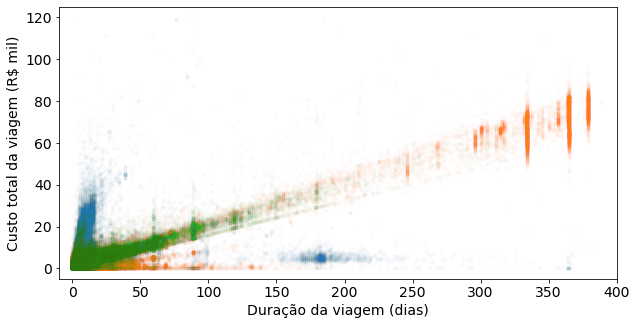

In [18]:
# Plot do custo das viagens por número de dias, por tipo (Internacional, Nacional e Sigilosa):
scale = 1000
pl.figure(figsize=(10,5))
pl.scatter(internacionais['Duração viagem'], internacionais['Valor total'] / scale, alpha=0.01, marker='.', label='Internacional')
pl.scatter(nacionais['Duração viagem'], nacionais['Valor total'] / scale, alpha=0.01, marker='.', label='Nacional')
pl.scatter(destino_vazio['Duração viagem'], destino_vazio['Valor total'] / scale, alpha=0.01, marker='.', label='Desconhecido')
#pl.legend(loc='upper left', fontsize=14)
pl.tick_params(labelsize=14)
pl.xlabel('Duração da viagem (dias)', fontsize=14)
pl.ylabel('Custo total da viagem (R$ mil)', fontsize=14)
pl.xlim(-10, 400)
pl.ylim([-5, 125])
pl.show()

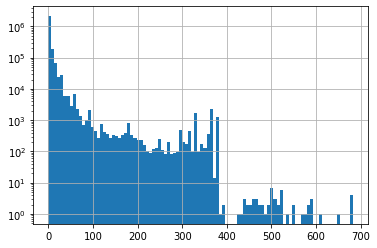

In [19]:
total_sel['Duração viagem'].hist(bins=100)
pl.yscale('log')
pl.show()

#### Distribuição temporal dos gastos

In [18]:
data_sel = total_sel[['Período - Data de início', 'Período - Data de fim', 'Duração viagem', 'Valor total']].copy()
data_sel['Custo diário'] = data_sel['Valor total'] / data_sel['Duração viagem'].clip(lower=1)

In [23]:
custo_por_periodo = data_sel.groupby(['Período - Data de início', 'Período - Data de fim'])['Custo diário'].sum().reset_index()

In [31]:
def total_trip_contributions(date):
    active_trips = custo_por_periodo.loc[(custo_por_periodo['Período - Data de início'] <= date) & (date <= custo_por_periodo['Período - Data de fim'])]
    return active_trips['Custo diário'].sum()

In [48]:
# Calculando contribuição das viagens para cada dia:
valor_gasto_distribuido = pd.DataFrame({'Data': pd.date_range(custo_por_periodo['Período - Data de início'].min(), custo_por_periodo['Período - Data de fim'].max())})
valor_gasto_distribuido['Valor'] = valor_gasto_distribuido['Data'].apply(total_trip_contributions)
valor_gasto_distribuido['Média móvel'] = valor_gasto_distribuido['Valor'].rolling(7, center=True).mean()

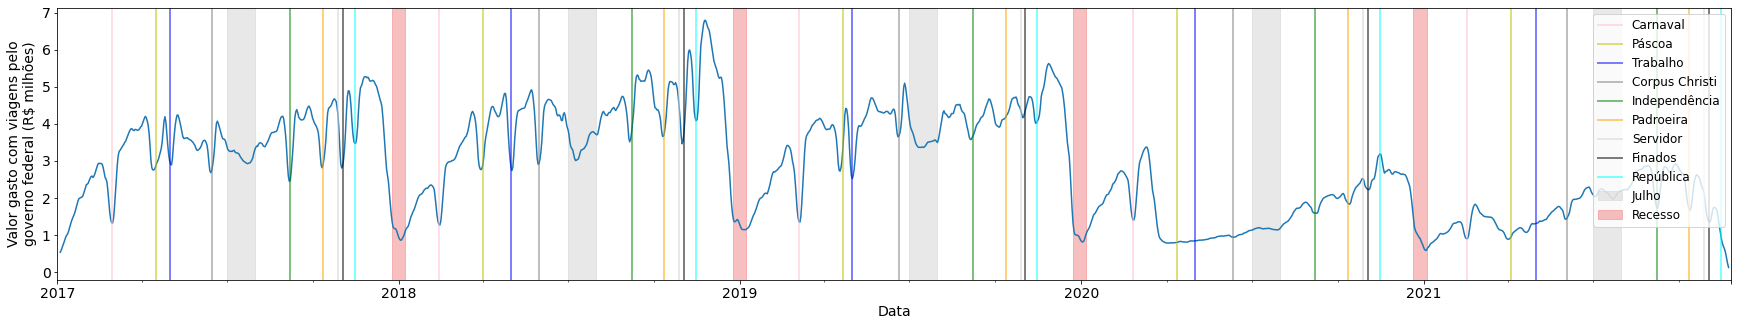

In [84]:
pl.figure(figsize=(30,5))
(valor_gasto_distribuido.set_index('Data', drop=True)['Média móvel'] / 1e6).plot(label='')
add_holidays()
pl.xlabel('Data', fontsize=14)
pl.ylabel('Valor gasto com viagens pelo\ngoverno federal (R$ milhões)', fontsize=14)
pl.tick_params(labelsize=14)
pl.legend(loc='upper right', fontsize=12)
pl.show()

#### Evolução temporal do número de viagens

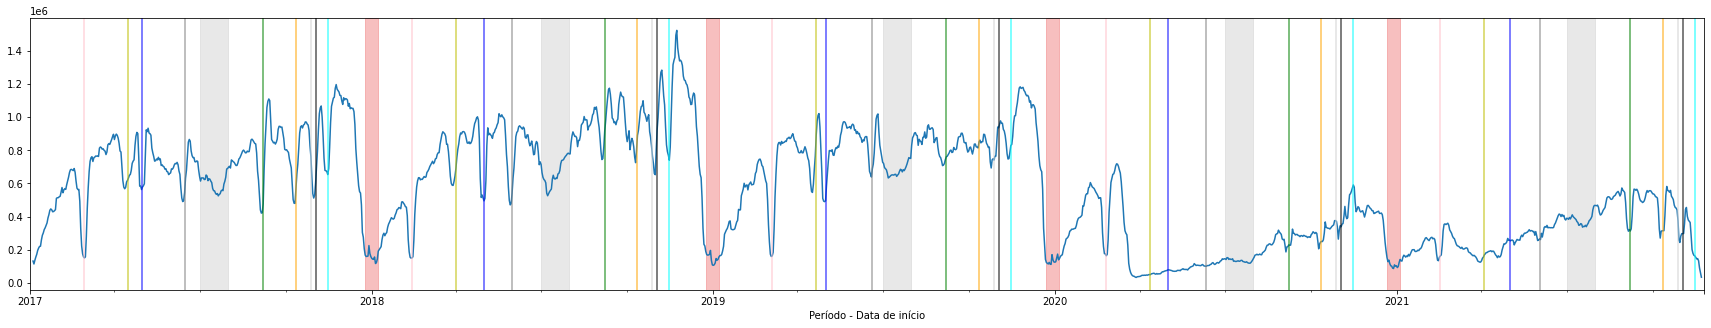

In [153]:
pl.figure(figsize=(30,5))
(total_sel['Valor total'] / total_sel['Duração viagem'].clip(lower=1)).groupby(total_sel['Período - Data de início']).sum().rolling(7, center=True).mean().plot()
add_holidays()
pl.show()

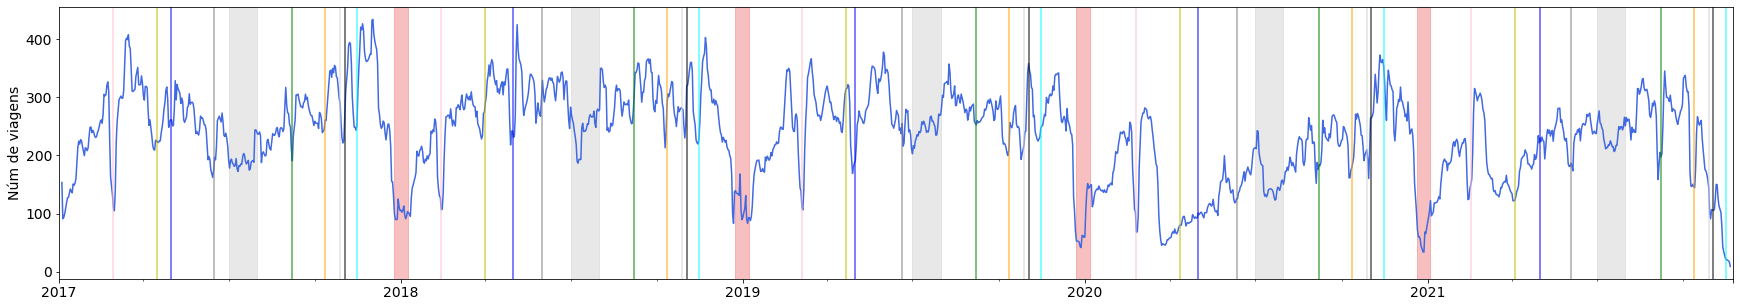

In [155]:
pl.figure(figsize=(30,5))
#trip_counts['trip_counts'].plot(color='lightblue')
sigilo_counts['trip_counts_mean'].plot(color='royalblue')
add_holidays()
#pl.grid(color='lightgray', linewidth=1)
pl.tick_params(labelsize=14)
pl.ylabel('Núm de viagens', fontsize=14)
pl.show()

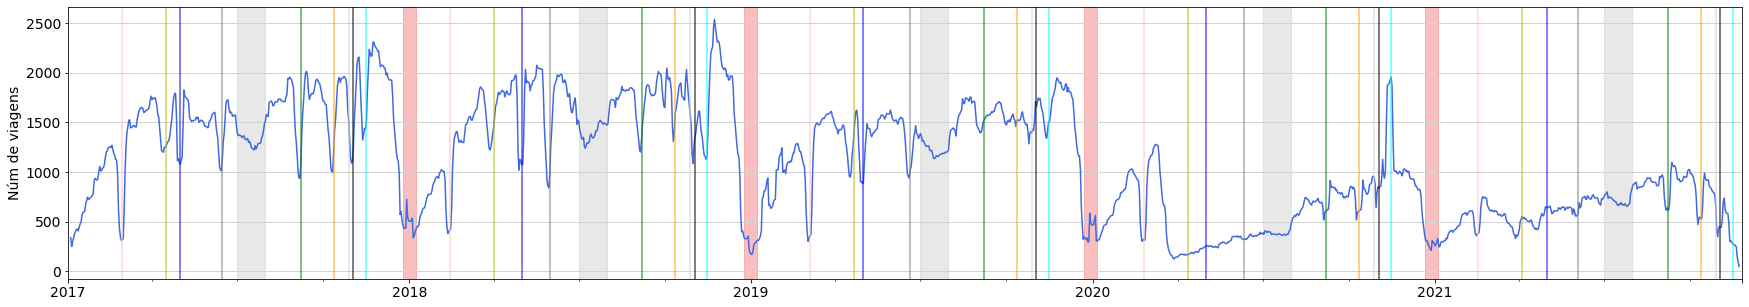

In [158]:
pl.figure(figsize=(30,5))
#trip_counts['trip_counts'].plot(color='lightblue')
nacionais_counts['trip_counts_mean'].plot(color='royalblue')
add_holidays()
pl.grid(axis='y', color='lightgray', linewidth=1)
pl.tick_params(labelsize=14)
pl.ylabel('Núm de viagens', fontsize=14)
pl.show()

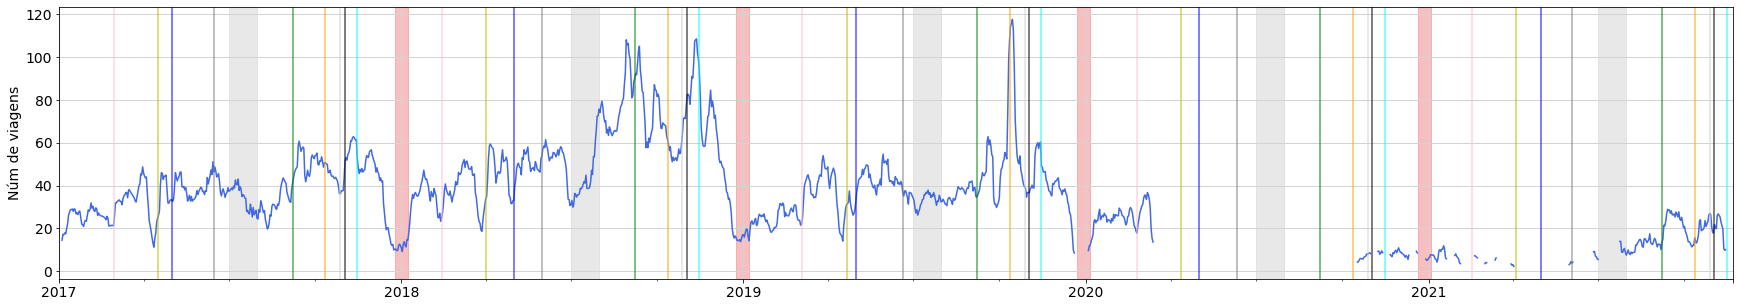

In [226]:
pl.figure(figsize=(30,5))
#trip_counts['trip_counts'].plot(color='lightblue')
internacionais_counts['trip_counts_mean'].plot(color='royalblue')
add_holidays()
pl.grid(color='lightgray', linewidth=1)
pl.tick_params(labelsize=14)
pl.ylabel('Núm de viagens', fontsize=14)
pl.show()

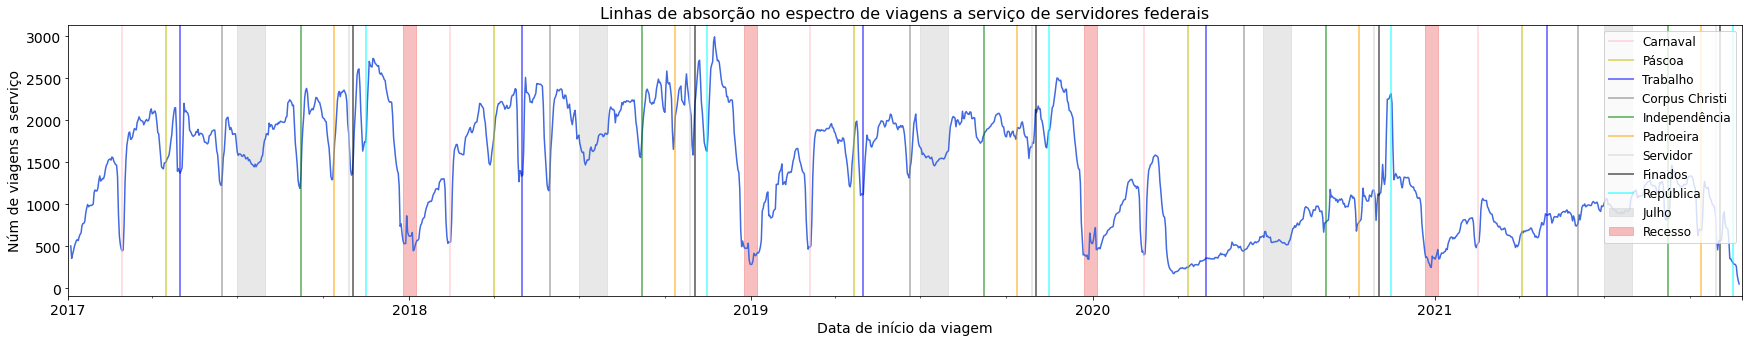

In [71]:
pl.figure(figsize=(30,5))
#trip_counts['trip_counts'].plot(color='lightblue')
trip_counts['trip_counts_mean'].plot(color='royalblue', label='')
#add_line('2020-03-15', 'Pandemia')
add_holidays()
pl.tick_params(labelsize=14)
pl.ylabel('Núm de viagens a serviço', fontsize=14)
pl.xlabel('Data de início da viagem', fontsize=14)
pl.legend(fontsize=12)
pl.title('Linhas de absorção no espectro de viagens a serviço de servidores federais', fontsize=16)
pl.show()

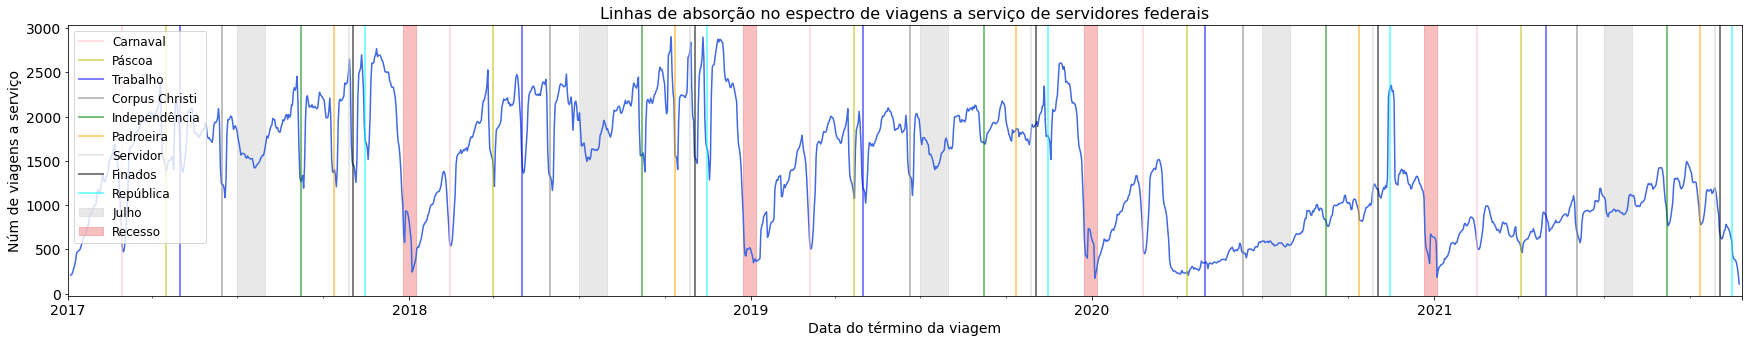

In [70]:
pl.figure(figsize=(30,5))
#trip_counts['trip_counts'].plot(color='lightblue')
end_trip_counts['trip_counts_mean'].plot(color='royalblue', label='')
#add_line('2020-03-15', 'Pandemia')
add_holidays()
pl.tick_params(labelsize=14)
pl.ylabel('Núm de viagens a serviço', fontsize=14)
pl.xlabel('Data do término da viagem', fontsize=14)
pl.legend(fontsize=12)
pl.title('Linhas de absorção no espectro de viagens a serviço de servidores federais', fontsize=16)
pl.show()

#### Investigação do pico em 12/10/2019

In [235]:
# Teste:
republica20 = internacionais.loc[(internacionais['Período - Data de início'] > '2019-10-10') & (internacionais['Período - Data de início'] < '2019-10-18')]
# Controle:
norep20     = internacionais.loc[((internacionais['Período - Data de início'] > '2019-10-05') & (internacionais['Período - Data de início'] < '2019-10-10')) | 
                            ((internacionais['Período - Data de início'] > '2019-10-18') & (internacionais['Período - Data de início'] < '2019-10-23'))]

In [249]:
republica20.columns

Index(['Identificador do processo de viagem', 'Número da Proposta (PCDP)',
       'Situação', 'Viagem Urgente', 'Justificativa Urgência Viagem',
       'Código do órgão superior', 'Nome do órgão superior',
       'Código órgão solicitante', 'Nome órgão solicitante', 'CPF viajante',
       'Nome', 'Cargo', 'Função', 'Descrição Função',
       'Período - Data de início', 'Período - Data de fim', 'Destinos',
       'Motivo', 'Valor diárias', 'Valor passagens', 'Valor outros gastos',
       'Número de trechos', 'Número diárias', 'Duração em dias',
       'Viagem Internacional', 'Número de passagens', 'Órgão superior',
       'Órgão', 'Valor pago', 'Duração viagem', 'Valor total',
       'Órgão superior padronizado', 'Órgão padronizado'],
      dtype='object')

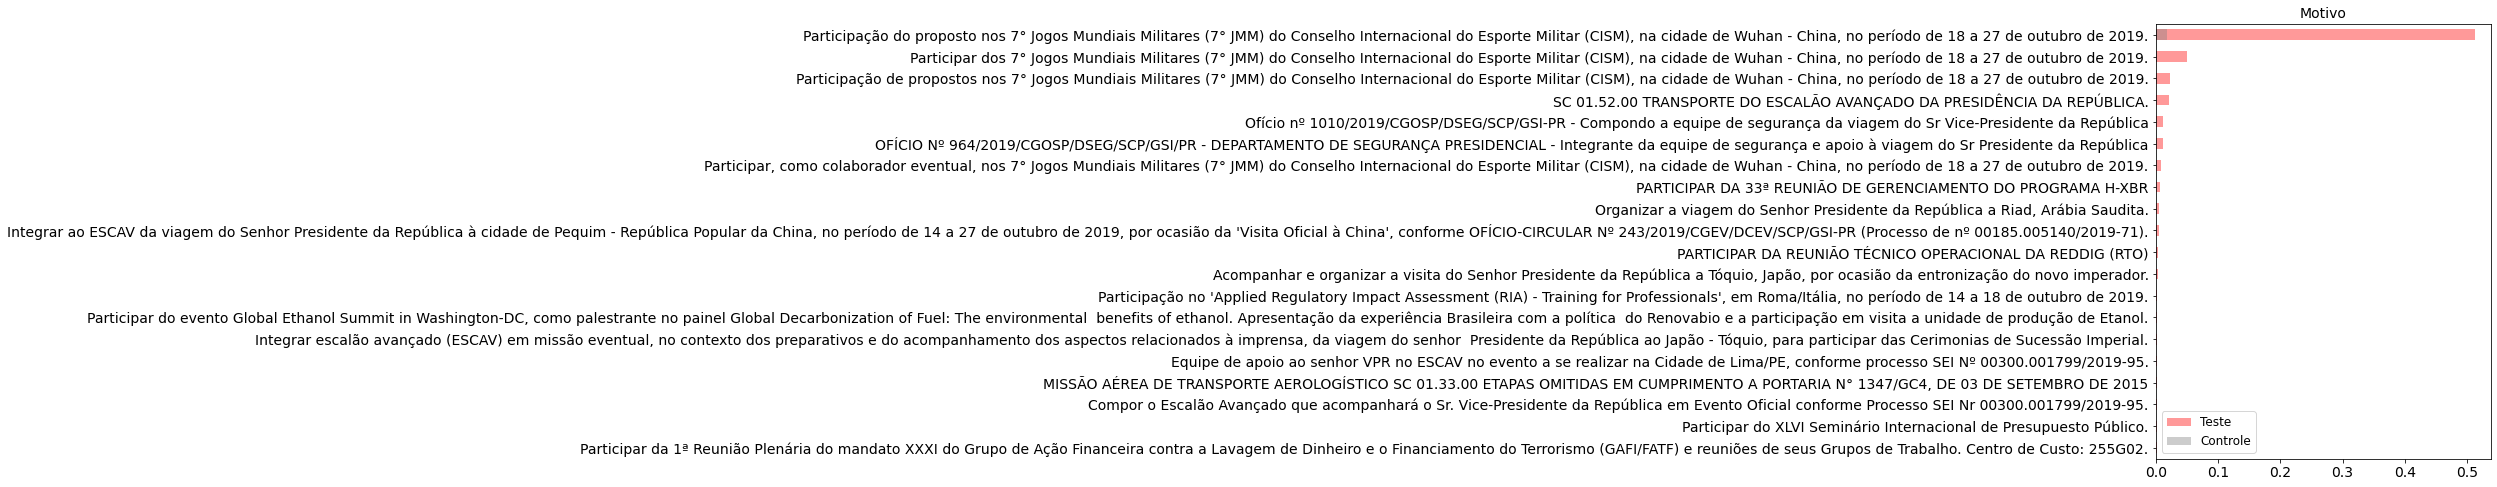

In [261]:
col = republica20.columns[17]

pl.figure(figsize=(6,8))
compare = pd.DataFrame()
compare['Teste']    = republica20[col].fillna('XXX').value_counts(normalize=True)
compare['Controle'] = norep20[col].fillna('XXX').value_counts(normalize=True)
compare.fillna(0, inplace=True)
compare.sort_values('Teste', inplace=True)
compare = compare.iloc[-20:]
compare['Teste'].plot(kind='barh', color='red', alpha=0.4, label='Teste')
compare['Controle'].plot(kind='barh', color='gray', alpha=0.4, label='Controle')
pl.legend(fontsize=12)
pl.tick_params(labelsize=14)
pl.title(col, fontsize=14)
pl.show()

* Min. Defesa
* Sargentos sem cargo
* P/ Wuhan, China, para participar no 7o jogos mundiais militares

#### Investigação do pico em 15/11/2020

In [188]:
# Teste:
republica20 = nacionais.loc[(nacionais['Período - Data de início'] > '2020-11-10') & (nacionais['Período - Data de início'] < '2020-11-16')]
# Controle:
norep20     = nacionais.loc[((nacionais['Período - Data de início'] > '2020-11-05') & (nacionais['Período - Data de início'] < '2020-11-10')) | 
                            ((nacionais['Período - Data de início'] > '2020-11-16') & (nacionais['Período - Data de início'] < '2020-11-20'))]

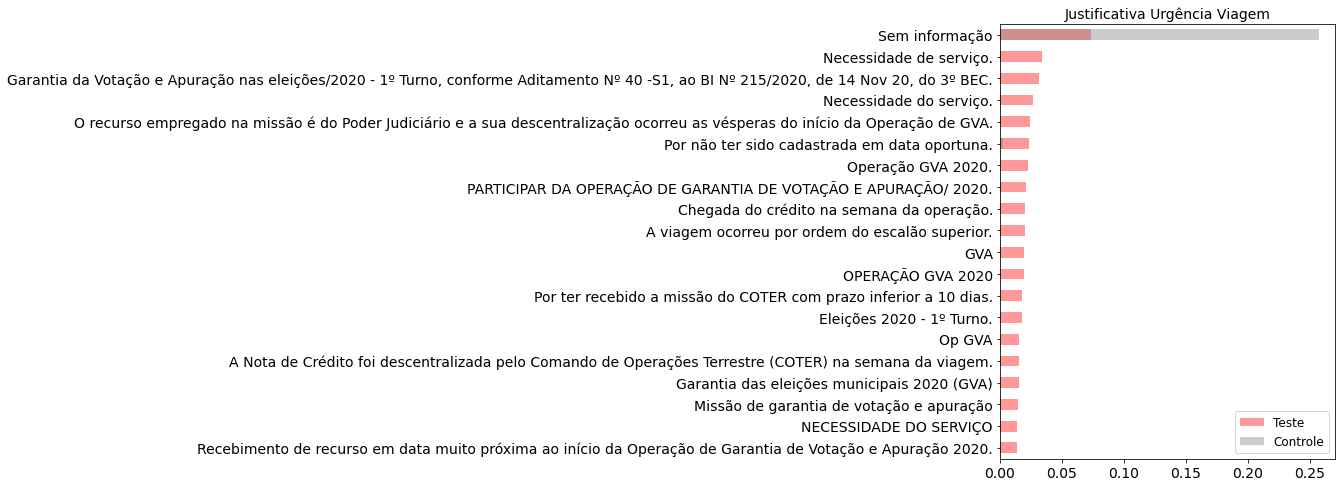

In [219]:
col = republica20.columns[4]

pl.figure(figsize=(6,8))
compare = pd.DataFrame()
compare['Teste']    = republica20[col].fillna('XXX').value_counts(normalize=True)
compare['Controle'] = norep20[col].fillna('XXX').value_counts(normalize=True)
compare.fillna(0, inplace=True)
compare.sort_values('Teste', inplace=True)
compare = compare.iloc[-20:]
compare['Teste'].plot(kind='barh', color='red', alpha=0.4, label='Teste')
compare['Controle'].plot(kind='barh', color='gray', alpha=0.4, label='Controle')
pl.legend(fontsize=12)
pl.tick_params(labelsize=14)
pl.title(col, fontsize=14)
pl.show()

## Exploração dos dados

In [36]:
# Hard-coded:
float_cols = ['Número Diárias', 'Valor da passagem', 'Taxa de serviço', 'Valor', 'Valor diárias', 'Valor passagens', 'Valor outros gastos']
date_cols  = ['Origem - Data', 'Destino - Data', 'Período - Data de início', 'Período - Data de fim']

### Trechos

In [37]:
trechos = load_cgu_csv('../dados/brutos/2018_20211128_Viagens/2018_Trecho.csv', float_cols, date_cols)

#### Identificando viagens nacionais e internacionais

In [111]:
trecho_internacional = find_trecho_internacional(trechos)   
viagem_internacional = trecho_internacional.groupby(trechos['Identificador do processo de viagem']).any().astype(int)

#### Origem/destino inválidos

In [24]:
trechos.loc[trechos['Destino - País'].str.contains('inv.lido|sigilo|desc|sem', case=False)]

,Identificador do processo de viagem,Número da Proposta (PCDP),Sequência Trecho,Origem - Data,Origem - País,Origem - UF,Origem - Cidade,Destino - Data,Destino - País,Destino - UF,Destino - Cidade,Meio de transporte,Número Diárias,Missao?
2065260,2018001144,Sem informação,2,12/06/2018,Brasil,São Paulo,São Paulo,15/06/2018,Inválido,Inválido,Inválido,Veículo Próprio,"3,00",Não
2065633,2018001415,Sem informação,2,30/07/2018,Brasil,Santa Catarina,Chapecó,01/08/2018,Inválido,Inválido,Inválido,Veículo Próprio,"2,00",Não
2065834,2018001579,Sem informação,2,17/07/2018,Brasil,Paraná,Francisco Beltrão,17/07/2018,Inválido,Inválido,Inválido,Veículo Próprio,"0,00",Não
2065914,2018001648,Sem informação,1,29/08/2018,Brasil,Distrito Federal,Brasília,04/09/2018,Inválido,Inválido,Inválido,Aéreo,"5,50",Não
2066327,2018001975,Sem informação,1,25/08/2018,Brasil,Rio de Janeiro,Rio de Janeiro,31/08/2018,Inválido,Inválido,Inválido,Aéreo,"5,50",Não
2066447,2018002101,Sem informação,3,10/09/2018,Angola,NaN,Luanda,13/09/2018,Inválido,Inválido,Inválido,Aéreo,"1,50",Não
2066620,2018002332,Sem informação,1,31/08/2018,Brasil,Distrito Federal,Brasília,08/09/2018,Inválido,Inválido,Inválido,Aéreo,"2,00",Não
2066627,2018002335,Sem informação,1,08/09/2018,Brasil,Distrito Federal,Brasília,12/09/2018,Inválido,Inválido,Inválido,Aéreo,"3,50",Não
2067042,2018003035,Sem informação,1,02/12/2018,Brasil,Rio de Janeiro,Rio de Janeiro,06/12/2018,Inválido,Inválido,Inválido,Aéreo,"3,50",Não
2067247,2018003249,Sem informação,2,28/11/2018,Brasil,São Paulo,São Paulo,29/11/2018,Inválido,Inválido,Inválido,Veículo Oficial,"1,00",Não


In [23]:
trechos.loc[trechos['Origem - País'].str.contains('inv.lido|sigilo|desc|sem', case=False)]

,Identificador do processo de viagem,Número da Proposta (PCDP),Sequência Trecho,Origem - Data,Origem - País,Origem - UF,Origem - Cidade,Destino - Data,Destino - País,Destino - UF,Destino - Cidade,Meio de transporte,Número Diárias,Missao?
2065259,2018001144,Sem informação,3,15/06/2018,Inválido,Inválido,Inválido,15/06/2018,Brasil,São Paulo,São Paulo,Veículo Próprio,"0,00",Não
2065631,2018001415,Sem informação,3,01/08/2018,Inválido,Inválido,Inválido,01/08/2018,Brasil,Santa Catarina,Chapecó,Veículo Próprio,"0,00",Não
2065835,2018001579,Sem informação,3,17/07/2018,Inválido,Inválido,Inválido,17/07/2018,Brasil,Paraná,Francisco Beltrão,Veículo Próprio,"0,00",Não
2065915,2018001648,Sem informação,2,04/09/2018,Inválido,Inválido,Inválido,04/09/2018,Brasil,Distrito Federal,Brasília,Aéreo,"0,50",Não
2066326,2018001975,Sem informação,2,31/08/2018,Inválido,Inválido,Inválido,01/09/2018,Brasil,Rio de Janeiro,Rio de Janeiro,Aéreo,"1,50",Não
2066448,2018002101,Sem informação,4,13/09/2018,Inválido,Inválido,Inválido,14/09/2018,Angola,NaN,Luanda,Aéreo,"1,00",Não
2066621,2018002332,Sem informação,2,08/09/2018,Inválido,Inválido,Inválido,09/09/2018,Brasil,Distrito Federal,Brasília,Aéreo,"1,50",Não
2066628,2018002335,Sem informação,2,12/09/2018,Inválido,Inválido,Inválido,15/09/2018,Lituânia,NaN,Vilnius,Aéreo,"3,00",Não
2067041,2018003035,Sem informação,2,06/12/2018,Inválido,Inválido,Inválido,07/12/2018,Brasil,Rio de Janeiro,Rio de Janeiro,Aéreo,"1,50",Não
2067249,2018003249,Sem informação,3,29/11/2018,Inválido,Inválido,Inválido,29/11/2018,Brasil,São Paulo,São Paulo,Veículo Oficial,"0,00",Não


In [21]:
i = 4
trechos['Origem - País'].value_counts().iloc[i*20:(i+1)*20]

Nicarágua             3
Timor Leste           3
Uganda                3
Irlanda               3
Namíbia               3
Cingapura             3
Indonésia             2
Macedônia             2
Belarus               2
República Togolesa    2
Barbados              2
Tanzânia              2
Armênia               2
Líbano                2
Sri Lanka             2
Tunísia               2
Romênia               2
Moldávia              2
Noruega               2
Nepal                 2
Name: Origem - País, dtype: int64

#### Checkup geral

In [8]:
xe.checkMissing(trechos)

Colunas com valores faltantes:
         coluna      N     %
5   Origem - UF  28521  1.62
9  Destino - UF  28051   1.6


In [9]:
xe.mapUnique(trechos)


Identificador do processo de viagem: 724931 unique values.
(sample) 15767482,  15914682,  15917448,  15948701,  15954575,  15955421,  15983732,  16060195,  16184843,  16214740,  16462243,  16463712,  16502125,  16595676,  16638762,  16645073,  16671623,  16766390,  16771931,  16778695

Número da Proposta (PCDP): 91703 unique values.
(sample) 001267/19-1C,  002177/19,  002609/19,  004805/19-1C,  005377/19,  005619/19,  006235/19,  011008/19,  014043/19,  014442/19,  015798/19,  040789/19,  043561/19,  049681/19,  052192/19,  054493/19,  056973/19-1C,  059398/19,  060524/19,  067512/19

Sequência Trecho: 43 unique values.
(sample) 1,  3,  4,  5,  8,  10,  16,  20,  21,  27,  29,  31,  34,  35,  36,  37,  38,  40,  41,  43

Origem - Data: 498 unique values.
(sample) 2019-01-03T00:00:00.000000000,  2019-01-19T00:00:00.000000000,  2019-02-01T00:00:00.000000000,  2019-03-23T00:00:00.000000000,  2019-05-30T00:00:00.000000000,  2019-07-13T00:00:00.000000000,  2019-07-14T00:00:00.000000000,  2

#### Significado da coluna Missão

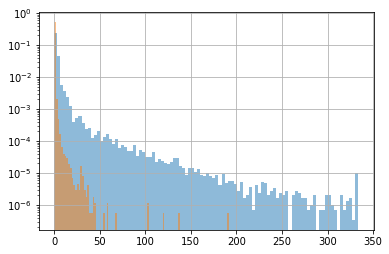

In [171]:
trechos.loc[trechos['Missao?'] == 'Sim', 'Número Diárias'].hist(bins=100, alpha=0.5, label='Sim', density=True)
trechos.loc[trechos['Missao?'] == 'Não', 'Número Diárias'].hist(bins=100, alpha=0.5, label='Não', density=True)
pl.yscale('log')

### Passagens

In [38]:
passagens = load_cgu_csv('../dados/brutos/2018_20211128_Viagens/2018_Passagem.csv', float_cols, date_cols)

In [27]:
xe.checkMissing(passagens)

Colunas com valores faltantes:
                    coluna       N     %
4          UF - Origem ida   13841  2.76
7         UF - Destino ida   19159  3.82
10       UF - Origem volta    5099  1.02
13      UF - Destino volta    1139  0.23
17  Data da emissão/compra  501708   100


In [79]:
xe.mapUnique(passagens)


Identificador do processo de viagem: 237562 unique values.
(sample) 15836548,  15885121,  15908658,  15916480,  15926920,  15933153,  16010316,  16078748,  16088971,  16130762,  16140686,  16289007,  16355472,  16356293,  16395371,  16436529,  16576539,  16614562,  16670973,  16731416

Número da Proposta (PCDP): 40706 unique values.
(sample) 001969/19,  004605/19,  009665/19,  011210/19,  012670/19,  013109/19,  015141/19,  026741/19,  028285/19,  029502/19,  030375/19,  031151/19,  033740/19,  038017/19,  039986/19,  044951/19,  048553/19,  058916/19-1C,  064369/19,  067518/19

Meio de transporte: 3 unique values.
Aéreo,  Fluvial,  Rodoviário

País - Origem ida: 153 unique values.
(sample) Albânia,  Austrália,  Azerbaidjão,  Catar,  China,  Croácia,  Guiné Bissau,  Hong Kong,  Itália,  Malauí,  Mauritânia,  MÉXICO,  Nepal,  República Dominicana,  República Togolesa,  Suriname,  Tailândia,  Vietnã,  Zimbábue,  Índia

UF - Origem ida: 29 unique values.
(sample) Acre,  Alagoas,  Amapá, 

<AxesSubplot:>

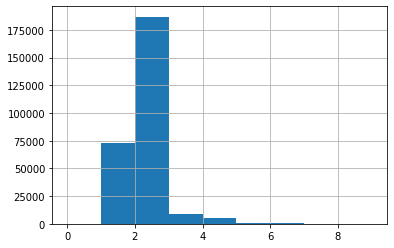

In [28]:
passagens['Identificador do processo de viagem'].value_counts().hist(bins=np.arange(0,10))

### Pagamentos

In [39]:
pagamentos = load_cgu_csv('../dados/brutos/2018_20211128_Viagens/2018_Pagamento.csv', float_cols, date_cols)

In [30]:
xe.checkMissing(pagamentos)

Colunas com valores faltantes:
                  coluna       N      %
5  Nome do órgao pagador  183791  11.23


In [31]:
xe.mapUnique(pagamentos)


Identificador do processo de viagem: 947358 unique values.
(sample) 14678570,  14701940,  14753281,  14829663,  14856255,  14882601,  14959179,  14991236,  15190163,  15210464,  15219538,  15279242,  15284729,  15297560,  15497055,  15586499,  15592579,  15606905,  15661472,  15733687

Número da Proposta (PCDP): 6173 unique values.
(sample) 001028/18-1C,  001474/18,  002283/18-1C,  003524/18,  004438/18-1C,  004483/18,  005076/18,  005476/18,  007024/18,  020592/18-1C,  025411/18,  028507/18,  036078/18,  038443/18,  039926/18,  046017/18-1C,  050517/18,  056877/18,  061511/18,  066560/18

Código do órgão superior: 20 unique values.
-1,  20000,  22000,  24000,  25000,  26000,  30000,  32000,  35000,  36000,  37000,  39000,  41000,  44000,  52000,  53000,  54000,  55000,  63000,  81000

Nome do órgão superior: 21 unique values.
(sample) Advocacia-Geral da União,  Controladoria-Geral da União,  Ministério da Agricultura, Pecuária e Abastecimento,  Ministério da Cidadania,  Ministério da

In [32]:
pagamentos['Nome do órgão superior'].value_counts()

Ministério da Educação                                         482991
Ministério da Economia                                         272835
Sigiloso                                                       183624
Ministério da Defesa                                           183273
Ministério da Saúde                                             94948
Ministério da Justiça e Segurança Pública                       88282
Ministério da Agricultura, Pecuária e Abastecimento             85153
Ministério do Meio Ambiente                                     48844
Ministério da Infraestrutura                                    45799
Presidência da República                                        20460
Ministério de Minas e Energia                                   19689
Ministério do Desenvolvimento Regional                          18569
Ministério da Cidadania                                         17942
Ministério da Ciência, Tecnologia, Inovações e Comunicações     15431
Ministério do Turism

In [33]:
pagamentos['Nome do órgao pagador'].value_counts()

Ministério da Economia - Unidades com vínculo direto    106686
Comando da Aeronáutica                                  105833
Instituto Nacional do Seguro Social                      92325
Fundo Nacional de Segurança Pública                      59671
Comando do Exército                                      58664
                                                         ...  
Instituto Nacional de Tecnologia da Informação             112
Caixa de Financiamento Imobiliário da Aeronáutica           83
Fundo Nacional do Meio Ambiente                             29
Fundo de Imprensa Nacional                                  21
Universidade Federal do Rio Grande do Norte                  1
Name: Nome do órgao pagador, Length: 194, dtype: int64

### Viagens

In [40]:
viagem = load_cgu_csv('../dados/brutos/2018_20211128_Viagens/2018_Viagem.csv', float_cols, date_cols)

In [142]:
xe.checkMissing(viagem)

Colunas com valores faltantes:
              coluna       N      %
9       CPF viajante       4      0
11             Cargo  261551  31.06
13  Descrição Função       9      0
17            Motivo       1      0


In [143]:
xe.mapUnique(viagem)


Identificador do processo de viagem: 842195 unique values.
(sample) 15822046,  15872502,  15913890,  15923563,  16006627,  16054627,  16105943,  16138721,  16186485,  16214869,  16217118,  16531526,  16549123,  16553685,  16553948,  16656681,  16664661,  16681475,  16697202,  16785675

Número da Proposta (PCDP): 93372 unique values.
(sample) 002297/19,  003382/19,  005652/19,  007651/19-1C,  012704/19,  017439/19,  025195/19,  029117/19,  029586/19,  031024/19-1C,  037614/19-1C,  046186/19,  055580/19,  059083/19,  060337/19-2C,  060435/19-1C,  065378/19,  069911/19,  072379/19-1C,  082664/19

Situação: 2 unique values.
Não realizada,  Realizada

Viagem Urgente: 1 unique values.
NÃO

Justificativa Urgência Viagem: 2 unique values.
Informação protegida por sigilo nos termos da legislação vigente,  Sem informação

Código do órgão superior: 25 unique values.
(sample) -1,  20000,  20113,  24000,  25000,  28000,  30000,  32000,  35000,  36000,  37000,  38000,  39000,  41000,  42000,  44000

#### Tempo de duração da viagem

In [35]:
dt = (viagem['Período - Data de fim'] - viagem['Período - Data de início']).dt.days

TypeError: unsupported operand type(s) for -: 'str' and 'str'

<AxesSubplot:>

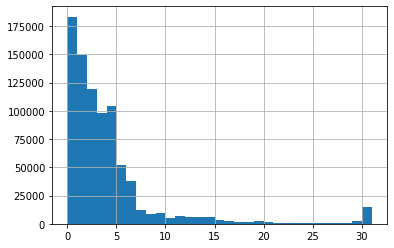

In [193]:
dt.clip(upper=31).hist(bins=np.arange(0,32))

#### O Número do Processo NCDP

In [199]:
xe.one2oneViolations(viagem, 'Identificador do processo de viagem', 'Número da Proposta (PCDP)')

Series([], Name: Número da Proposta (PCDP), dtype: object)

In [200]:
xe.one2oneViolations(viagem, 'Número da Proposta (PCDP)', 'Identificador do processo de viagem')

Número da Proposta (PCDP)
000001/19          [15362986, 15388828, 15510768, 15673386, 15707...
000002/19                   [15769974, 15841488, 15919556, 16617044]
000003/19          [15518600, 15783458, 15794029, 15919928, 16601...
000004/19                                       [15755550, 15764433]
000005/19                             [15453339, 15784466, 16618324]
                                         ...                        
067073/19                                       [16514010, 16640910]
067074/19                                       [16481601, 16640946]
067075/19                                       [16641116, 16823288]
Informações pro    [15355834, 15355867, 15416039, 15416105, 15528...
Sem informação     [15045825, 15100682, 15114708, 15163874, 15166...
Name: Identificador do processo de viagem, Length: 41422, dtype: object

In [203]:
viagem.loc[viagem['Número da Proposta (PCDP)'] == '067075/19'].transpose()

,700148,838035
Identificador do processo de viagem,16641116,16823288
Número da Proposta (PCDP),067075/19,067075/19
Situação,Realizada,Realizada
Viagem Urgente,NÃO,NÃO
Justificativa Urgência Viagem,Sem informação,Sem informação
Código do órgão superior,52000,52000
Nome do órgão superior,Ministério da Defesa,Ministério da Defesa
Código órgão solicitante,52111,52121
Nome órgão solicitante,Comando da Aeronáutica,Comando do Exército
CPF viajante,***.652.116-**,***.186.770-**


### Concordândia entre informações de tabelas diferentes

In [48]:
completa = build_df_completa(viagem, trechos, passagens, pagamentos)

In [17]:
completa.sample(3).transpose()

,613234,495547,720006
Identificador do processo de viagem,16526425,16379921,16666637
Número da Proposta (PCDP),025150/19,Sem informação,004333/19
Situação,Realizada,Realizada,Realizada
Viagem Urgente,NÃO,NÃO,NÃO
Justificativa Urgência Viagem,Sem informação,Sem informação,Sem informação
Código do órgão superior,36000,52000,26000
Nome do órgão superior,Ministério da Saúde,Ministério da Defesa,Ministério da Educação
Código órgão solicitante,36000,52121,26274
Nome órgão solicitante,Ministério da Saúde - Unidades com vínculo direto,Comando do Exército,Fundação Universidade Federal de Uberlândia
CPF viajante,***.000.000-**,***.472.357-**,***.200.088-**


#### Valores da viagem vs. pagos

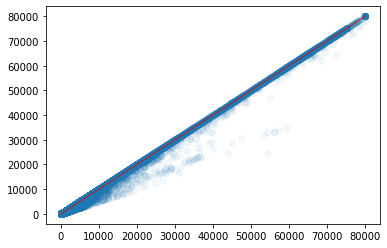

In [112]:
max_val = 80000
pl.scatter((completa['Valor diárias'] + completa['Valor passagens'] + completa['Valor outros gastos']).clip(upper=max_val), completa['Valor pago'].clip(upper=max_val), alpha=0.05)
x = np.array([0, max_val])
pl.plot(x, x, color='firebrick', linewidth=1)
pl.show()

#### Órgão solicitante e órgão pagador

A maioria dos casos de desacordo decorre de sigilo ou falta de informação sobre o órgão pagador:

In [72]:
# Fração com mesmo solicitante e pagador superior:
len(completa.loc[completa['Nome do órgão superior'] == completa['Órgão superior']]) / len(completa)

0.7394047696792311

In [80]:
# Seleciona entradas com informação completa:
sim_orgao = completa.loc[~completa['Nome do órgão superior'].isin(['Sem informação']) & ~completa['Órgão superior'].isin(['Sigiloso', 'Sem informação']) & ~completa['Órgão superior'].isnull()]

In [83]:
# Fração com informações conflitantes é muito pequena:
len(sim_orgao.loc[sim_orgao['Nome do órgão superior'] != sim_orgao['Órgão superior'], ['Nome do órgão superior', 'Órgão superior']]) / len(sim_orgao)

0.00919803215254

In [82]:
sim_orgao.loc[sim_orgao['Nome do órgão superior'] != sim_orgao['Órgão superior'], ['Nome do órgão superior', 'Órgão superior']].sample(10)

,Nome do órgão superior,Órgão superior
576331,Presidência da República,"Ministério da Mulher, Família e Direitos Humanos"
313765,Presidência da República,"Ministério da Mulher, Família e Direitos Humanos"
158185,Ministério do Trabalho e Emprego,Ministério da Economia
112594,Ministério do Trabalho e Emprego,Ministério da Economia
509520,Presidência da República,"Ministério da Mulher, Família e Direitos Humanos"
688969,Presidência da República,"Ministério da Mulher, Família e Direitos Humanos"
7670,Ministério do Trabalho e Emprego,Ministério da Economia
113428,Ministério do Trabalho e Emprego,Ministério da Economia
131625,Ministério do Trabalho e Emprego,Ministério da Economia
75430,Ministério do Trabalho e Emprego,Ministério da Economia


In [58]:
completa.loc[completa['Nome do órgão superior'] != completa['Órgão superior'], ['Nome do órgão superior', 'Órgão superior']].sample(10)

,Nome do órgão superior,Órgão superior
84583,Ministério da Justiça e Segurança Pública,Sigiloso
355989,Sem informação,Ministério de Minas e Energia
596733,Ministério da Justiça e Segurança Pública,NaN
499937,Ministério da Justiça e Segurança Pública,Sigiloso
685497,Sem informação,Ministério da Economia
171990,Ministério da Justiça e Segurança Pública,Sigiloso
371671,Ministério da Justiça e Segurança Pública,Sigiloso
382578,Ministério do Meio Ambiente,NaN
352289,Sem informação,Ministério da Economia
615356,Sem informação,Ministério da Economia


In [74]:
completa.loc[(completa['Nome do órgão superior'] != completa['Órgão superior']) & ~completa['Órgão superior'].isin(['Sigiloso']) & ~completa['Órgão superior'].isnull(), ['Nome do órgão superior', 'Órgão superior']].sample(10)

,Nome do órgão superior,Órgão superior
461386,Sem informação,Ministério da Economia
232550,Sem informação,Ministério da Economia
168082,Sem informação,Ministério de Minas e Energia
492615,Sem informação,Ministério da Justiça e Segurança Pública
307150,Sem informação,Ministério da Economia
364959,Sem informação,Ministério da Justiça e Segurança Pública
158578,Sem informação,Ministério da Cidadania
770093,Sem informação,Ministério da Economia
574374,Presidência da República,"Ministério da Mulher, Família e Direitos Humanos"
743892,Sem informação,Ministério da Economia


In [84]:
# Fração com mesmo solicitante e pagador:
len(completa.loc[completa['Nome órgão solicitante'] == completa['Órgão']]) / len(completa)

0.7033857954511722

In [107]:
sim_orgao2 = completa.loc[~completa['Órgão'].isnull()  & ~completa['Nome órgão solicitante'].isin(['Sem informação'])]

In [108]:
# Fração com informações conflitantes:
len(sim_orgao2.loc[(sim_orgao2['Nome órgão solicitante'] != sim_orgao2['Órgão'])]) / len(sim_orgao2)

0.057463436986876774

In [106]:
completa.loc[(completa['Nome órgão solicitante'] != completa['Órgão']) & ~completa['Órgão'].isnull()  & ~completa['Nome órgão solicitante'].isin(['Sem informação']), ['Nome órgão solicitante', 'Órgão']].sample(10)

,Nome órgão solicitante,Órgão
667498,Comando do Exército,Fundo do Exército
151650,Ministério do Trabalho e Emprego - Unidades co...,Ministério da Economia - Unidades com vínculo ...
271745,Ministério da Infraestrutura - Unidades com ví...,Agência Nacional de Aviação Civil
516792,Comando do Exército,Fundo do Exército
188286,Presidência da República - Unidades com víncul...,Presidência da República
715077,Presidência da República - Unidades com víncul...,Presidência da República
544123,Secretaria de Direitos Humanos,"Ministério da Mulher, Família e Direitos Human..."
162172,Ministério do Trabalho e Emprego - Unidades co...,Ministério da Economia - Unidades com vínculo ...
778927,Presidência da República - Unidades com víncul...,Presidência da República
23703,Presidência da República - Unidades com víncul...,Presidência da República


In [90]:
completa.loc[completa['Nome órgão solicitante'] != completa['Órgão'], ['Nome órgão solicitante', 'Órgão']].sample(10)

,Nome órgão solicitante,Órgão
681727,Sem informação,NaN
772617,Ministério da Educação - Unidades com vínculo ...,Instituto Federal do Rio Grande do Norte
87361,Instituto Nacional do Seguro Social,NaN
709946,Sem informação,Ministério da Economia - Unidades com vínculo ...
257378,Departamento de Polícia Rodoviária Federal,NaN
324161,Ministério da Infraestrutura - Unidades com ví...,Agência Nacional de Aviação Civil
444967,Departamento de Polícia Rodoviária Federal,NaN
306737,Departamento de Polícia Rodoviária Federal,NaN
545305,Presidência da República - Unidades com víncul...,Presidência da República
604543,Controladoria-Geral da União - Unidades com ví...,NaN


#### Duração e diárias

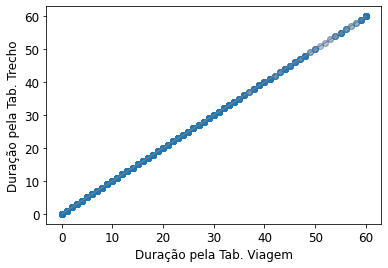

In [51]:
max_days = 60
pl.scatter((completa['Período - Data de fim'] - completa['Período - Data de início']).dt.days.clip(upper=max_days), completa['Duração em dias'].clip(upper=max_days), alpha=0.01)
x = [0, max_days]
pl.plot(x, x, color='gray', linewidth=1)
pl.xlabel('Duração pela Tab. Viagem', fontsize=12)
pl.ylabel('Duração pela Tab. Trecho', fontsize=12)
pl.tick_params(labelsize=12)
pl.show()

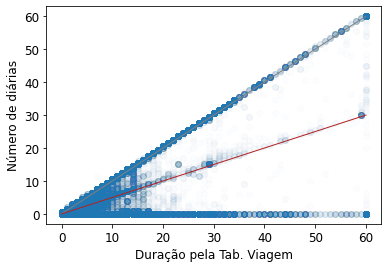

In [54]:
max_days = 60
pl.scatter((completa['Período - Data de fim'] - completa['Período - Data de início']).dt.days.clip(upper=max_days), completa['Número diárias'].clip(upper=max_days), alpha=0.01)
x = np.array([0, max_days])
pl.plot(x, x, color='gray', linewidth=1)
pl.plot(x, x / 2, color='firebrick', linewidth=1)
pl.xlabel('Duração pela Tab. Viagem', fontsize=12)
pl.ylabel('Número de diárias', fontsize=12)
pl.tick_params(labelsize=12)
pl.show()

#### Número de trechos e número de passagens

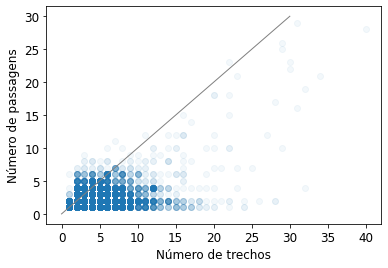

In [22]:
pl.scatter(completa['Número de trechos'], completa['Número de passagens'], alpha=0.05)
x = [0,30]
pl.plot(x,x, color='gray', linewidth=1)
pl.xlabel('Número de trechos', fontsize=12)
pl.ylabel('Número de passagens', fontsize=12)
pl.tick_params(labelsize=12)
pl.show()

#### Multiplicidade de entradas p/ a mesma viagem

In [24]:
viagem['Identificador do processo de viagem'].value_counts()

16779263    1
15786825    1
15827813    1
15829860    1
15840099    1
           ..
16752990    1
16757084    1
16746843    1
16744794    1
16779265    1
Name: Identificador do processo de viagem, Length: 842195, dtype: int64

In [40]:
trechos['Identificador do processo de viagem'].value_counts()

15837261    43
15819057    40
16748195    36
15836818    36
16751098    36
            ..
16469472     1
16741337     1
16749411     1
16572642     1
16258218     1
Name: Identificador do processo de viagem, Length: 724931, dtype: int64

In [42]:
passagens['Identificador do processo de viagem'].value_counts()

15844380    29
15819057    28
15813353    26
15823361    25
15805785    23
            ..
16247871     1
15996623     1
16043732     1
16494058     1
15819180     1
Name: Identificador do processo de viagem, Length: 237562, dtype: int64

In [43]:
pagamentos['Identificador do processo de viagem'].value_counts()

15844380    60
15873077    55
15873147    55
15873279    54
15823361    53
            ..
16142486     1
16138388     1
16146576     1
16158862     1
16779265     1
Name: Identificador do processo de viagem, Length: 779086, dtype: int64

#### Validação de valores das passagens

In [93]:
values_df = pd.DataFrame()
values_df['passagem_viagem']    = viagem.set_index('Identificador do processo de viagem')['Valor passagens']
values_df['passagem_passagens'] = passagens['Valor da passagem'].groupby(passagens['Identificador do processo de viagem']).sum()
values_df['taxa_passagens']     = passagens['Taxa de serviço'].groupby(passagens['Identificador do processo de viagem']).sum()
values_df['total_passagens']    = values_df['taxa_passagens'] + values_df['passagem_passagens']

In [106]:
xe.checkMissing(values_df)

Colunas com valores faltantes:
               coluna       N      %
1  passagem_passagens  604633  71.79
2      taxa_passagens  604633  71.79
3     total_passagens  604633  71.79


In [103]:
# Total de viagens:
len(values_df)

842195

In [102]:
# Valores que não batem:
len(values_df.loc[~np.isclose(values_df['passagem_viagem'], values_df['total_passagens'])])

604661

In [105]:
# Valores que não batem pois gasto com passagem não existe:
len(values_df.loc[~np.isclose(values_df['passagem_viagem'], values_df['total_passagens']) & (values_df['passagem_viagem'] == 0) & values_df['passagem_passagens'].isnull()])

569983

In [100]:
# Existe gasto com passagem mas não está especificado na tabela "Passagem":
len(values_df.loc[~np.isclose(values_df['passagem_viagem'], values_df['total_passagens']) & (values_df['passagem_viagem'] != 0) & values_df['passagem_passagens'].isnull()])

34650

In [99]:
# Valores nas tabelas "Viagem" e "Passagem" não batem:
len(values_df.loc[~np.isclose(values_df['passagem_viagem'], values_df['total_passagens']) & (values_df['passagem_viagem'] != 0) & ~values_df['passagem_passagens'].isnull()])

28

In [108]:
bad_values_df = values_df.loc[~np.isclose(values_df['passagem_viagem'], values_df['total_passagens']) & (values_df['passagem_viagem'] != 0) & ~values_df['passagem_passagens'].isnull()].copy()
bad_values_df['total_x2'] = bad_values_df['total_passagens'] * 2

In [151]:
bad_values_df.join(viagem.set_index('Identificador do processo de viagem')['Situação'])

,passagem_viagem,passagem_passagens,taxa_passagens,total_passagens,total_x2,Situação
Identificador do processo de viagem,,,,,,
15773001,3415.04,1707.52,0.00,1707.52,3415.04,Realizada
15773025,3718.02,729.35,0.00,729.35,1458.70,Realizada
15778911,3026.54,1513.27,0.00,1513.27,3026.54,Realizada
15779019,3026.54,1513.27,0.00,1513.27,3026.54,Realizada
15908801,3860.50,1930.25,0.00,1930.25,3860.50,Realizada
15908992,3860.50,1930.25,0.00,1930.25,3860.50,Realizada
15909199,2729.46,1364.73,0.00,1364.73,2729.46,Realizada
15948420,5774.88,2887.44,0.00,2887.44,5774.88,Realizada
16062327,931.31,802.95,128.37,931.32,1862.64,Realizada


#### Cruzamento geral de dados de viagens selecionadas

* Múltiplas/muitas passagens para uma mesma viagem
* Trechos inválidos

Seleção de casos a serem detalhados

In [28]:
muitas_passagens = (completa.set_index('Identificador do processo de viagem')['Número de passagens'] - completa.set_index('Identificador do processo de viagem')['Número de trechos']).sort_values(ascending=False).index

In [29]:
multiplas_passagens = passagens['Identificador do processo de viagem'].value_counts().index

In [49]:
destino_invalido = trechos.loc[trechos['Destino - País'] == 'Inválido']['Identificador do processo de viagem'].drop_duplicates().values
origem_invalida  = trechos.loc[trechos['Origem - País'] == 'Inválido']['Identificador do processo de viagem'].drop_duplicates().values

Detalhamento

In [54]:
#viagem_id = multiplas_passagens[1000]
#viagem_id = muitas_passagens[3]
viagem_id = destino_invalido[4]

a_viagem = completa.loc[completa['Identificador do processo de viagem'] == viagem_id]
xd.print_string_series(a_viagem.transpose().iloc[:,0])
pag_cols =  ['Nome do órgão superior', 'Nome do órgao pagador', 'Nome da unidade gestora pagadora']
display(pagamentos.loc[pagamentos['Identificador do processo de viagem'] == viagem_id, pag_cols].drop_duplicates().sort_values(pag_cols))
display(trechos.loc[trechos['Identificador do processo de viagem'] == viagem_id].sort_values('Sequência Trecho'))
display(passagens.loc[passagens['Identificador do processo de viagem'] == viagem_id])

Identificador do processo de viagem: 2018001975
Número da Proposta (PCDP): Sem informação
Situação: Realizada
Viagem Urgente: NÃO
Justificativa Urgência Viagem: Sem informação
Código do órgão superior: 25000
Nome do órgão superior: Ministério da Economia
Código órgão solicitante: 25201
Nome órgão solicitante: Banco Central do Brasil - Orçamento Fiscal e Seguridade Social
CPF viajante: ***.634.137-**
Nome: LEANDRO DOS SANTOS FIGUEIREDO
Cargo: ANALISTA DO BANCO CENTRAL
Função: -1
Descrição Função: Não Informado
Período - Data de início: 2018-08-25 00:00:00
Período - Data de fim: 2018-09-01 00:00:00
Destinos: Sem informação
Motivo: Participar do evento Banking Crisis and Resolution Course.
Valor diárias: 7473.81
Valor passagens: 3017.65
Valor outros gastos: 231.6
Número de trechos: 2.0
Número diárias: 7.0
Duração em dias: 7.0
Número de passagens: 2.0
Órgão superior: Ministério da Economia
Órgão: Banco Central do Brasil - Orçamento Fiscal e Seguridade Social
Valor pago: 10723.060000000001


,Nome do órgão superior,Nome do órgao pagador,Nome da unidade gestora pagadora
1633944,Ministério da Economia,Banco Central do Brasil - Orçamento Fiscal e S...,BANCO CENTRAL DO BRASIL


,Identificador do processo de viagem,Número da Proposta (PCDP),Sequência Trecho,Origem - Data,Origem - País,Origem - UF,Origem - Cidade,Destino - Data,Destino - País,Destino - UF,Destino - Cidade,Meio de transporte,Número Diárias,Missao?
2066327,2018001975,Sem informação,1,2018-08-25,Brasil,Rio de Janeiro,Rio de Janeiro,2018-08-31,Inválido,Inválido,Inválido,Aéreo,5.5,Não
2066326,2018001975,Sem informação,2,2018-08-31,Inválido,Inválido,Inválido,2018-09-01,Brasil,Rio de Janeiro,Rio de Janeiro,Aéreo,1.5,Não


,Identificador do processo de viagem,Número da Proposta (PCDP),Meio de transporte,País - Origem ida,UF - Origem ida,Cidade - Origem ida,País - Destino ida,UF - Destino ida,Cidade - Destino ida,País - Origem volta,UF - Origem volta,Cidade - Origem volta,Pais - Destino volta,UF - Destino volta,Cidade - Destino volta,Valor da passagem,Taxa de serviço,Data da emissão/compra,Hora da emissão/compra
499652,2018001975,Sem informação,Aéreo,Inválido,Inválido,Inválido,Brasil,Rio de Janeiro,Rio de Janeiro,Sem Informação,Sem Informação,Sem Informação,Sem Informação,Sem Informação,Sem Informação,1559.58,0.0,NaN,00:00
499653,2018001975,Sem informação,Aéreo,Brasil,Rio de Janeiro,Rio de Janeiro,Inválido,Inválido,Inválido,Sem Informação,Sem Informação,Sem Informação,Sem Informação,Sem Informação,Sem Informação,1458.07,0.0,NaN,00:00
